# I. Data Preprocessing 

# 1. Load Necessary Libraries

In [35]:
# Load necessary libraries
library(tidyverse)    # For data manipulation and visualization
library(lubridate)    # For date manipulation (if needed)
library(arules)       # For Market Basket Analysis
library(cluster)      # For clustering algorithms
library(factoextra)   # For visualizing clustering results
library(FactoMineR)   # For PCA

# 2. Load and Inspect the Dataset

In [36]:
# Load the dataset (replace the path with your actual file path)
data <- read.csv("E:/Projects/R/Sales_Transactions_Dataset_Weekly - Copy.csv")

# Display the first few rows of the dataset
head(data)

# Perform EDA (Exploratory Data Analysis)
summary(data)

,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,⋯,W42,W43,W44,W45,W46,W47,W48,W49,W50,W51
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,P1,11,12,10,8,13,12,14,21,6,⋯,4,7,8,10,12,3,7,6,5,10
2,P2,7,6,3,2,7,1,6,3,3,⋯,2,4,5,1,1,4,5,1,6,0
3,P3,7,11,8,9,10,8,7,13,12,⋯,6,14,5,5,7,8,14,8,8,7
4,P4,12,8,13,5,9,6,9,13,13,⋯,9,10,3,4,6,8,14,8,7,8
5,P5,8,5,13,11,6,7,9,14,9,⋯,7,11,7,12,6,6,5,11,8,9
6,P6,3,3,2,7,6,3,8,6,6,⋯,4,2,4,3,6,5,3,3,10,6


 Product_Code             W0               W1               W2       
 Length:811         Min.   : 0.000   Min.   : 0.000   Min.   : 0.00  
 Class :character   1st Qu.: 0.000   1st Qu.: 0.000   1st Qu.: 0.00  
 Mode  :character   Median : 3.000   Median : 3.000   Median : 3.00  
                    Mean   : 8.903   Mean   : 9.129   Mean   : 9.39  
                    3rd Qu.:12.000   3rd Qu.:12.000   3rd Qu.:12.00  
                    Max.   :54.000   Max.   :53.000   Max.   :56.00  
       W3               W4               W5               W6       
 Min.   : 0.000   Min.   : 0.000   Min.   : 0.000   Min.   : 0.00  
 1st Qu.: 0.000   1st Qu.: 0.000   1st Qu.: 0.000   1st Qu.: 0.00  
 Median : 4.000   Median : 4.000   Median : 3.000   Median : 4.00  
 Mean   : 9.718   Mean   : 9.575   Mean   : 9.466   Mean   : 9.72  
 3rd Qu.:13.000   3rd Qu.:13.000   3rd Qu.:12.500   3rd Qu.:13.00  
 Max.   :59.000   Max.   :61.000   Max.   :52.000   Max.   :56.00  
       W7               W8        

# 3. Data Preparation

In [37]:
# Convert data to a data frame
data_df <- as.data.frame(data)

# Function to detect and remove outliers based on Z-score
remove_outliers <- function(x, threshold = 4) {
  if (is.numeric(x)) {
    outlier_indices <- which(abs(scale(x)) > threshold)
    x[outlier_indices] <- NA  # Mark outliers as NA
  }
  return(x)
}

# Identify numeric columns (excluding Product_Code)
numeric_cols <- sapply(data_df, is.numeric)

# Remove outliers from numeric columns
data_df[, numeric_cols] <- lapply(data_df[, numeric_cols], remove_outliers)

# Normalize the data
data_df[, numeric_cols] <- scale(data_df[, numeric_cols])

# 4. Prepare Data for PCA

In [38]:
# Ensure Product_Code is treated as row names
data_df <- data_df %>% column_to_rownames(var = "Product_Code")

# Convert to matrix for PCA
data_matrix <- as.matrix(data_df)

# Check if row names are correctly set
print(head(rownames(data_matrix)))
print(dim(data_matrix))

[1] "P1" "P2" "P3" "P4" "P5" "P6"
[1] 811  52


# 5. Apply PCA

In [39]:
# Apply PCA
pca <- PCA(data_matrix, scale.unit = TRUE, ncp = 2, graph = FALSE)

# Use PCA scores for clustering
pca_scores <- pca$ind$coord

Warning message in PCA(data_matrix, scale.unit = TRUE, ncp = 2, graph = FALSE):
"Missing values are imputed by the mean of the variable: you should use the imputePCA function of the missMDA package"


# 6. Compute Silhouette Width

In [40]:
# Function to compute silhouette width
compute_silhouette <- function(pca_scores, clusters) {
  require(cluster)
  silhouette_info <- silhouette(clusters, dist(pca_scores))
  avg_silhouette_width <- mean(silhouette_info[, 3])
  return(avg_silhouette_width)
}

# II. K-means Clustering

### Determine the Optimal Number of Clusters

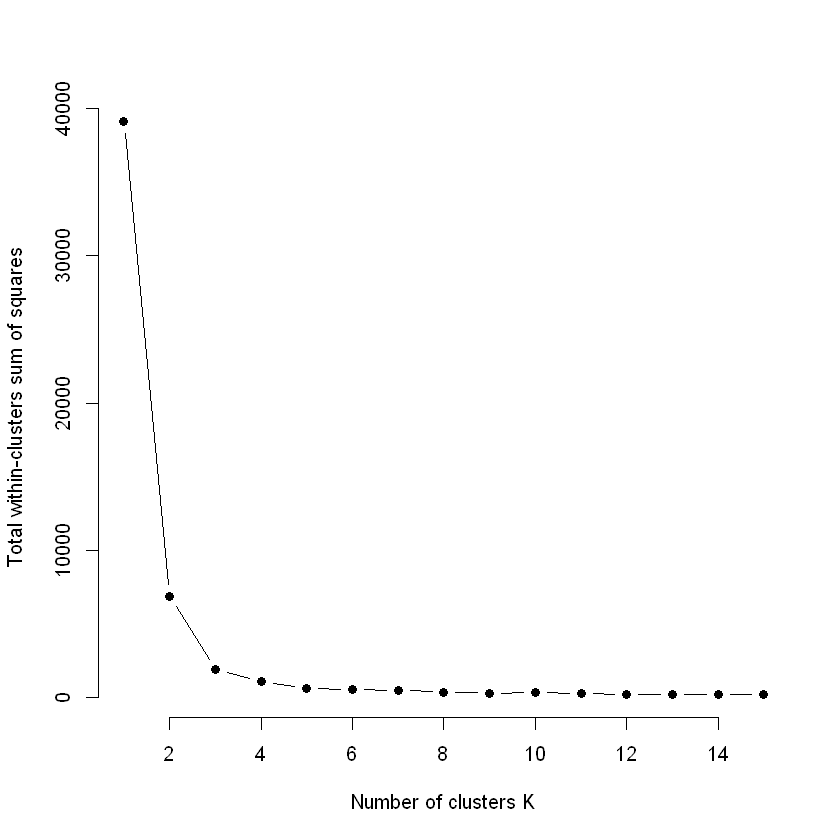

In [7]:
# Determine the optimal number of clusters using the Elbow method
wss <- (nrow(pca_scores) - 1) * sum(apply(pca_scores, 2, var))
for (i in 2:15) wss[i] <- sum(kmeans(pca_scores, centers = i, nstart = 20)$tot.withinss)

# Plot the Elbow method result
plot(1:15, wss, type = "b", pch = 19, frame = FALSE, xlab = "Number of clusters K", ylab = "Total within-clusters sum of squares")

In [8]:
# Set the optimal number of clusters (example: K = 3 based on the Elbow method)
optimal_k <- 3

# Apply k-means clustering
set.seed(123)
kmeans_result <- kmeans(pca_scores, centers = optimal_k, nstart = 50, iter.max = 500)

# Get the clusters
clusters <- kmeans_result$cluster

### Evaluate Clustering Quality

[1] "Average Silhouette Width:  0.741987822365957"
  cluster size ave.sil.width
1       1  197          0.58
2       2  490          0.78
3       3  124          0.86


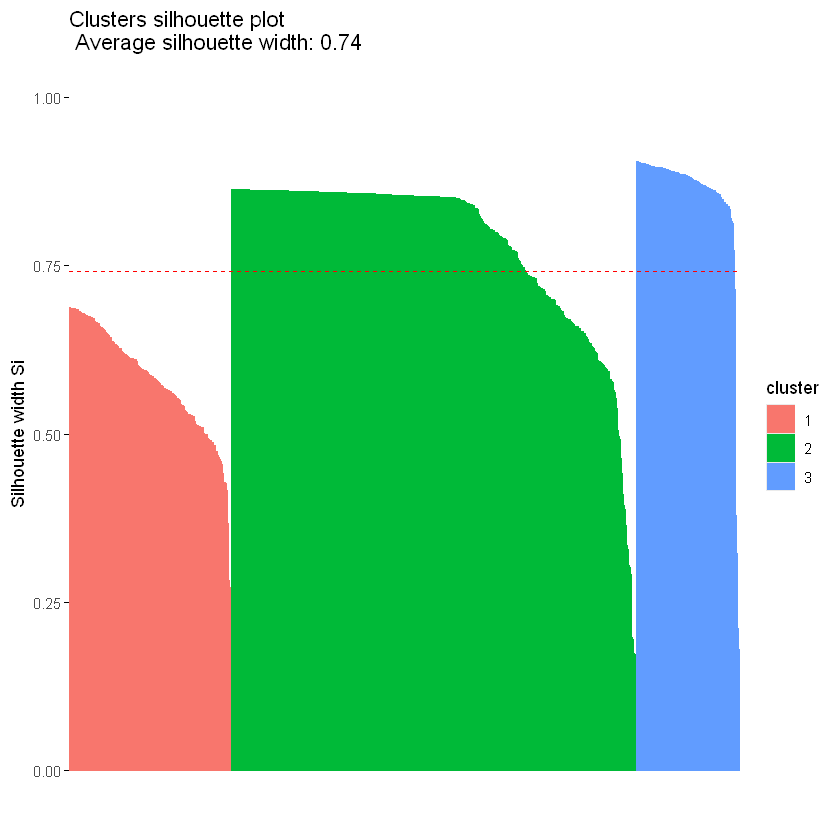

In [9]:
# Evaluate Clustering Quality

# Compute silhouette width
avg_silhouette_width <- compute_silhouette(pca_scores, clusters)
print(paste("Average Silhouette Width: ", avg_silhouette_width))

# Visualize the silhouette plot
fviz_silhouette(silhouette(clusters, dist(pca_scores)))

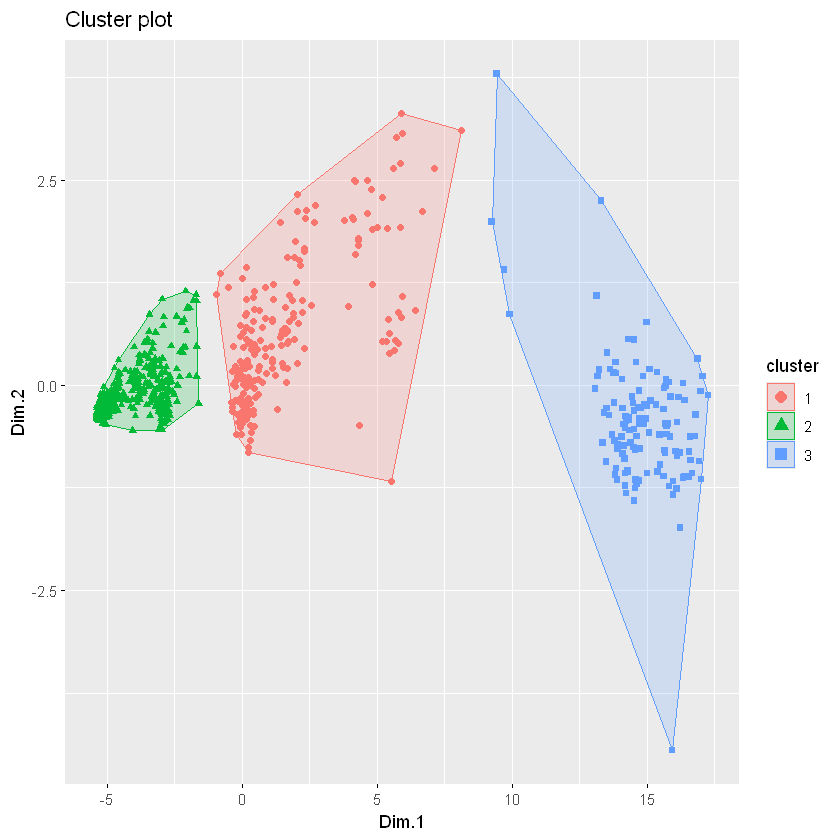

In [10]:
# Plot the clusters
fviz_cluster(list(data = pca_scores, cluster = clusters), geom = "point", stand = FALSE)

# III. Hierarchical Clustering Algorithm

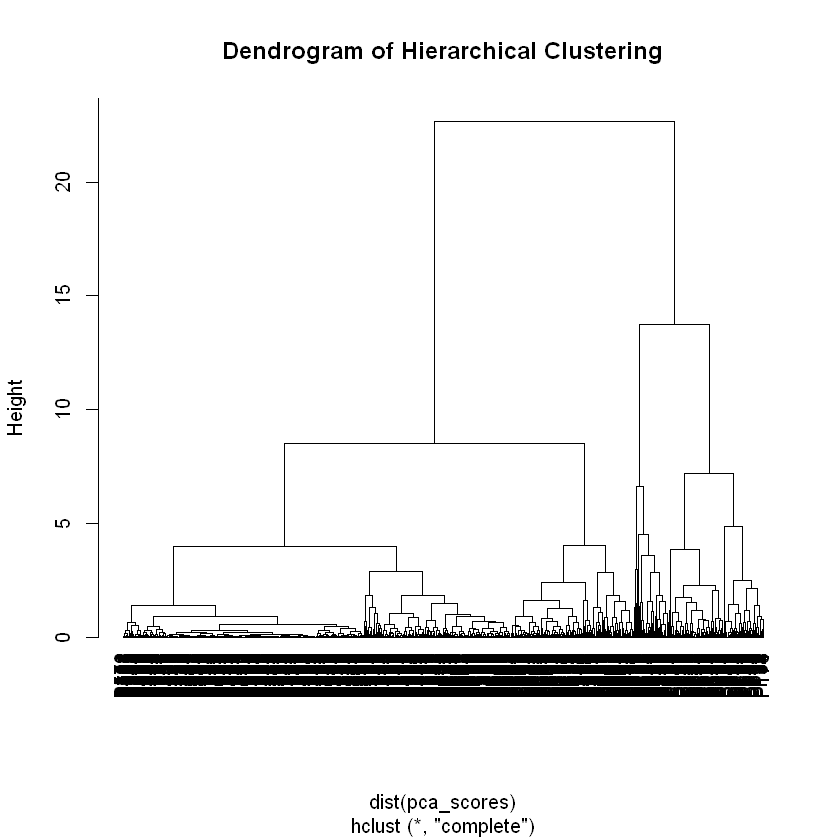

In [86]:
# Perform hierarchical clustering
hc_result <- hclust(dist(pca_scores))

# Visualize the dendrogram to aid threshold selection
plot(hc_result, hang = -1, main = "Dendrogram of Hierarchical Clustering")

In [87]:
# Setting the maximum distance threshold based on a graph where the threshold 
# is the height of the vertical line without intersecting the horizontal line.
max_dist_threshold <- 15  

# Cut the dendrogram using the selected maximum distance threshold
clusters_hc_maxdist <- cutree(hc_result, h = max_dist_threshold)

### Evaluate Clustering Quality

[1] "Hierarchical Clustering (Max Distance) Average Silhouette Width:  0.774054126174685"
  cluster size ave.sil.width
1       1  646          0.82
2       2  165          0.61


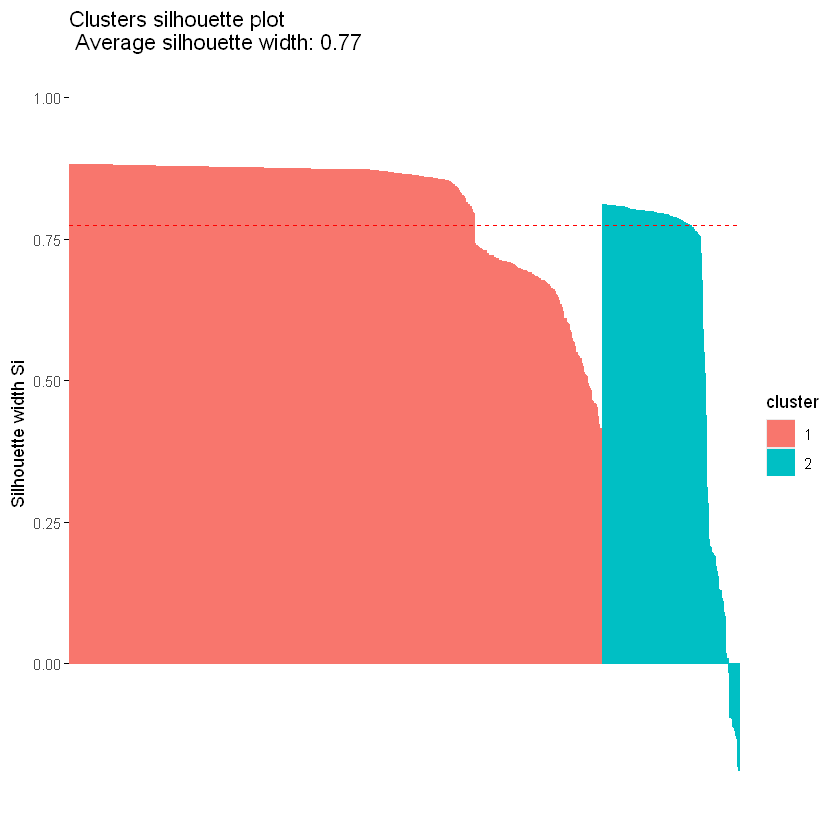

In [88]:
# Evaluate clustering quality with silhouette width
avg_silhouette_width_hc_maxdist <- compute_silhouette(pca_scores, clusters_hc_maxdist)
print(paste("Hierarchical Clustering (Max Distance) Average Silhouette Width: ", avg_silhouette_width_hc_maxdist))

# Visualize silhouette plot for maximum distance criterion
fviz_silhouette(silhouette(clusters_hc_maxdist, dist(pca_scores)))

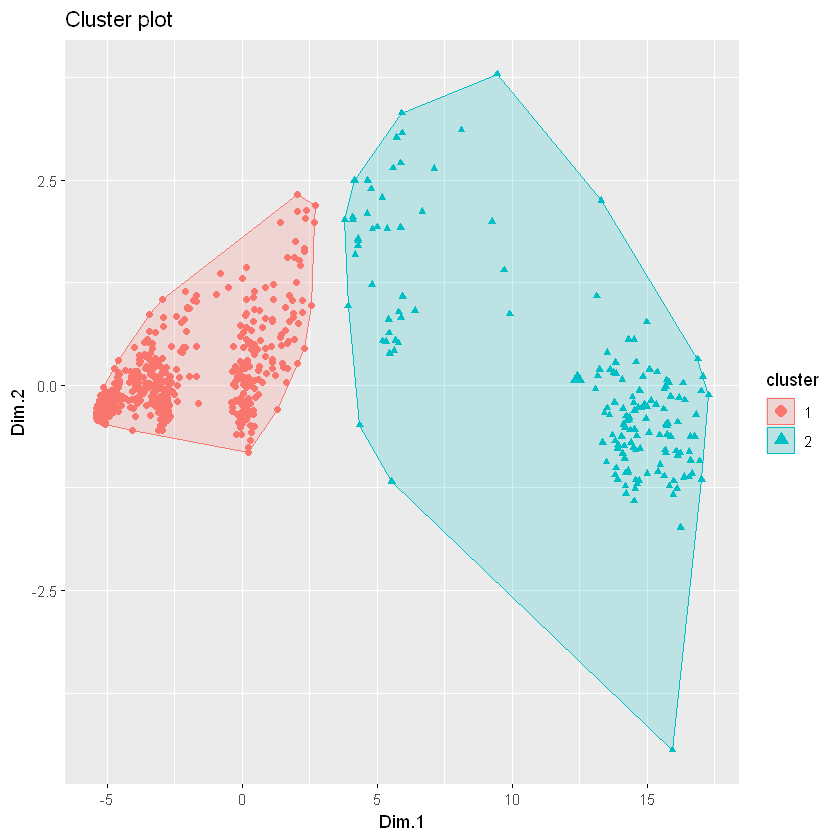

In [89]:
# Plot the clusters
fviz_cluster(list(data = pca_scores, cluster = clusters_hc_maxdist), geom = "point", stand = FALSE)

# IV. DBSCAN Algorithm

In [90]:
# DBSCAN Algorithm

library(dbscan)

In [91]:
# Perform DBSCAN clustering
dbscan_result <- dbscan(pca_scores, eps = 0.5, minPts = 10)

# Get clusters
clusters_db <- dbscan_result$cluster

# Handle noise points (cluster = 0)
clusters_db[clusters_db == 0] <- max(clusters_db) + 1

In [92]:
# Identify useful clusters (e.g., clusters 1, 2, and 3)
useful_clusters <- c(1, 2, 3)

# Replace non-useful clusters with NA
clusters_db[!clusters_db %in% useful_clusters] <- NA

### Evaluate Clustering Quality

[1] "DBSCAN Average Silhouette Width:  0.760330785441929"
  cluster size ave.sil.width
1       1  144          0.78
2       2  490          0.72
3       3  110          0.90


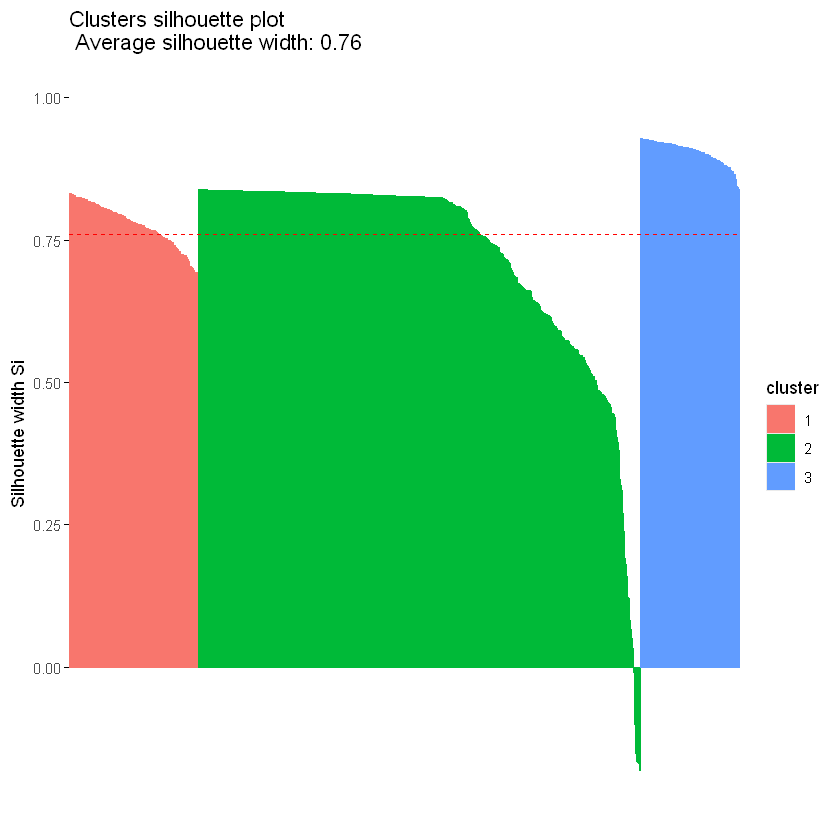

In [93]:
# Evaluate clustering quality with silhouette width (only for useful clusters)
valid_indices <- !is.na(clusters_db)
avg_silhouette_width_db <- compute_silhouette(pca_scores[valid_indices, ], clusters_db[valid_indices])
print(paste("DBSCAN Average Silhouette Width: ", avg_silhouette_width_db))

# Visualize silhouette plot
fviz_silhouette(silhouette(clusters_db[valid_indices], dist(pca_scores[valid_indices, ])))

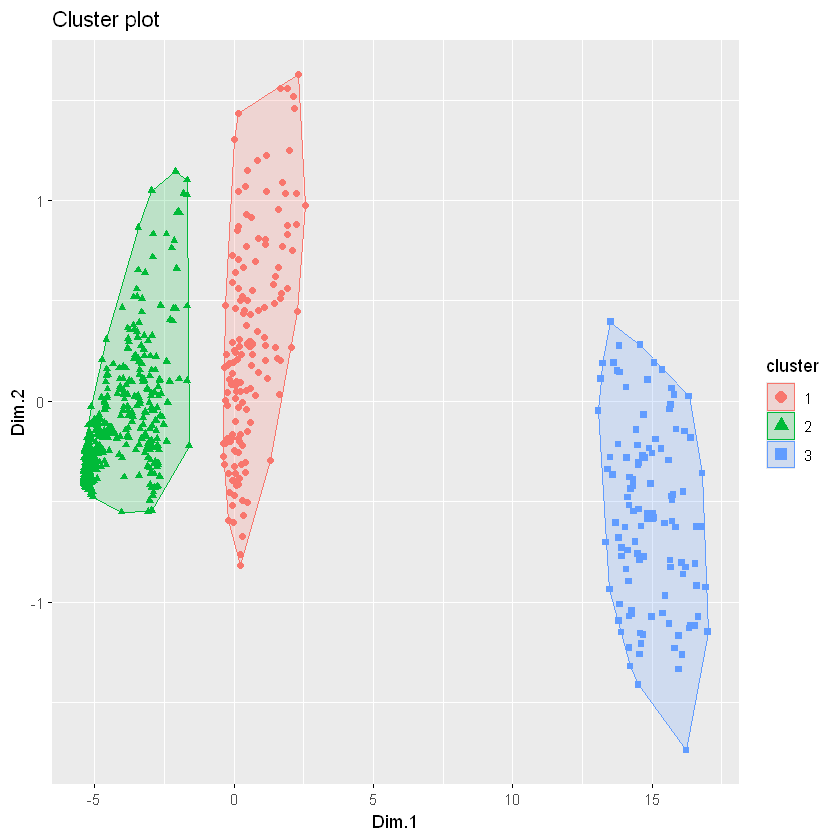

In [94]:
# Plot the clusters
# Only include points in useful clusters in the visualization
fviz_cluster(list(data = pca_scores[valid_indices, ], cluster = clusters_db[valid_indices]), geom = "point", stand = FALSE)

# V. Save information about clusters

In [95]:
# DBSCAN algorithm is selected as final model as it provides better performance
# Add cluster information to data_df
data_df$Cluster <- clusters_db

In [74]:
# Subset data_df to include Product_Code (as row names) and Cluster columns
data_subset <- data.frame(Product_Code = rownames(data_df), Cluster = data_df$Cluster)

In [75]:
# Save the subset to a CSV file with a valid file path
write.csv(data_subset, file = "clustered_product_clusters.csv", row.names = FALSE)